### Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline 

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score, matthews_corrcoef
from imblearn.metrics import geometric_mean_score

from sklearn.ensemble import RandomForestClassifier

#Sampling methods
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NeighbourhoodCleaningRule,OneSidedSelection
from imblearn.combine import SMOTETomek ,SMOTEENN

### Evaluation metrics to apply:


<strong>1. Accuracy:</strong>

$\frac{TP+TN}{TP + FP + FN + TN}$

<strong>2. Precision:</strong> 

$\frac{TP}{TP + FP}$

<strong>3. Recall:</strong> 

$\frac{TP}{TP + FN}$

<strong>4. F1 score:</strong> 

$2\times\frac{precision\times recall}{precision+recall}$

<strong>5. Geometric mean:</strong> 

$\sqrt{\frac{TP}{TP + FN}\times\frac{TN}{TN + FP}}$

<strong>6. Matthews correlation coefficient:</strong> 

$\frac{TP\times TN-FP\times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$

In [2]:
data=pd.read_csv(r'bank-additional\bank-additional\bank-additional-full.csv',sep=";")
data.y.value_counts()
train, test = train_test_split(data, test_size=0.2, random_state=0, stratify=data[['y']])
#As a suggestion in https://archive.ics.uci.edu/ml/datasets/bank+marketing, the column "duration" is dropped.
train=train.drop(columns='duration')
test=test.drop(columns='duration')

train_x=train.iloc[:,0:-1]
train_y=pd.DataFrame(train['y'])
train_y.y.replace('no',0,inplace=True)
train_y.y.replace('yes',1,inplace=True)

test_x=test.iloc[:,0:-1]
test_y=pd.DataFrame(test['y'])
test_y.y.replace('no',0,inplace=True)
test_y.y.replace('yes',1,inplace=True)

numerical_ix = train_x.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = train_x.select_dtypes(include=['object', 'bool']).columns

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)

scoring = {"Acc":"accuracy",
           'F1': 'f1', 
           'Prec': 'precision',
           'Recall':'recall',
           'MC':make_scorer(matthews_corrcoef),
          'GM':make_scorer(geometric_mean_score)}
rf=RandomForestClassifier(random_state=0)

### 1. Classification with imbalanced data

In [3]:
t0 = [('cat', OneHotEncoder(handle_unknown = "ignore"), categorical_ix)]
col_transform0 = ColumnTransformer(transformers=t0)

pipeline = Pipeline(steps=[('prep', col_transform0),('m',rf)])
cv_results_none=cross_validate(pipeline, train_x, train_y.values.ravel(), scoring=scoring, cv=kfold)

<IPython.core.display.Javascript object>

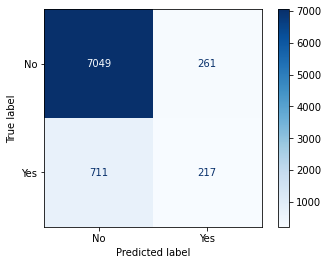

In [4]:
pipeline.fit(train_x,train_y.values.ravel())
predict_y=pipeline.predict(test_x)
plot_confusion_matrix(pipeline, test_x,test_y,display_labels=["No","Yes"], cmap=plt.cm.Blues) ; 

In [5]:
results = pd.DataFrame(columns=scoring.keys())
results.loc['No sampling']=  [np.mean(cv_results_none['test_{}'.format(score)]) for score in scoring.keys()] 
results 

,Acc,F1,Prec,Recall,MC,GM
No sampling,0.886829,0.334538,0.495452,0.252693,0.29887,0.4941


### 2. Synthetic Minority Oversampling Technique (SMOTE)

In [6]:
t = [('cat', OneHotEncoder(handle_unknown = "ignore"), categorical_ix), ('num', StandardScaler(), numerical_ix)]
col_transform = ColumnTransformer(transformers=t)

pipeline = Pipeline(steps=[('prep', col_transform),('imbalance',SMOTE()) ,('m',rf)])
cv_results_smote=cross_validate(pipeline, train_x, train_y.values.ravel(), scoring=scoring, cv=kfold)

results = pd.DataFrame(columns=scoring.keys())
results.loc['SMOTE']=  [np.mean(cv_results_smote['test_{}'.format(score)]) for score in scoring.keys()] 
results 

,Acc,F1,Prec,Recall,MC,GM
SMOTE,0.887375,0.42263,0.500287,0.366111,0.367421,0.590684


<IPython.core.display.Javascript object>

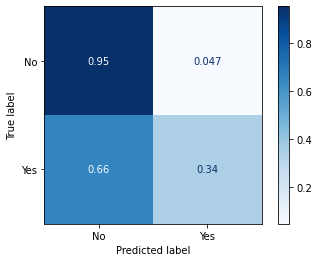

In [7]:
pipeline.fit(train_x,train_y.values.ravel())
predict_y=pipeline.predict(test_x)
plot_confusion_matrix(pipeline, test_x,test_y,display_labels=["No","Yes"], cmap=plt.cm.Blues,normalize='true'); 

### 3. Adaptive Synthetic (ADASYN)

In [8]:
pipeline = Pipeline(steps=[('prep', col_transform),('imbalance',ADASYN()) ,('m',rf)])
cv_results_adasyn=cross_validate(pipeline, train_x, train_y.values.ravel(), scoring=scoring, cv=kfold)

results = pd.DataFrame(columns=scoring.keys())
results.loc['ADASYN']=  [np.mean(cv_results_adasyn['test_{}'.format(score)]) for score in scoring.keys()] 
results 

,Acc,F1,Prec,Recall,MC,GM
ADASYN,0.886009,0.411002,0.491798,0.353182,0.355732,0.580149


<IPython.core.display.Javascript object>

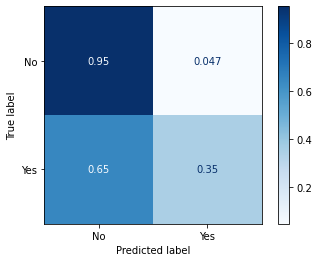

In [9]:
pipeline.fit(train_x,train_y.values.ravel())
predict_y=pipeline.predict(test_x)
plot_confusion_matrix(pipeline, test_x,test_y,display_labels=["No","Yes"], cmap=plt.cm.Blues,normalize='true');

### 4. NeighbourhoodCleaningRule

In [10]:
pipeline = Pipeline(steps=[('prep', col_transform),('imbalance',NeighbourhoodCleaningRule()) ,('m',rf)])
cv_results_ncr=cross_validate(pipeline, train_x, train_y.values.ravel(), scoring=scoring, cv=kfold)

results = pd.DataFrame(columns=scoring.keys())
results.loc['NCR']=  [np.mean(cv_results_ncr['test_{}'.format(score)]) for score in scoring.keys()] 
results 

,Acc,F1,Prec,Recall,MC,GM
NCR,0.873687,0.477718,0.447251,0.512931,0.407581,0.68667


<IPython.core.display.Javascript object>

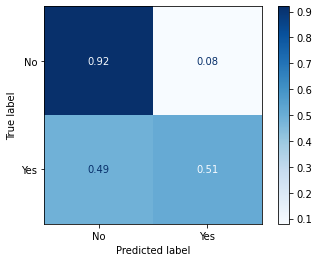

In [11]:
pipeline.fit(train_x,train_y.values.ravel())
predict_y=pipeline.predict(test_x)
plot_confusion_matrix(pipeline, test_x,test_y,display_labels=["No","Yes"], cmap=plt.cm.Blues,normalize='true');

### 5. OneSidedSelection

In [12]:
pipeline = Pipeline(steps=[('prep', col_transform),('imbalance',OneSidedSelection()) ,('m',rf)])
cv_results_oss=cross_validate(pipeline, train_x, train_y.values.ravel(), scoring=scoring, cv=kfold)

results = pd.DataFrame(columns=scoring.keys())
results.loc['OSS']=  [np.mean(cv_results_oss['test_{}'.format(score)]) for score in scoring.keys()] 
results

,Acc,F1,Prec,Recall,MC,GM
OSS,0.891138,0.424114,0.525346,0.355873,0.375051,0.584104


<IPython.core.display.Javascript object>

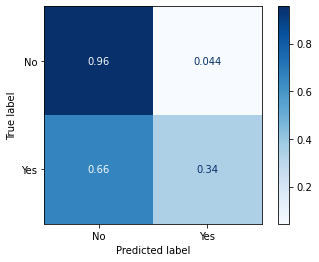

In [13]:
pipeline.fit(train_x,train_y.values.ravel())
predict_y=pipeline.predict(test_x)
plot_confusion_matrix(pipeline, test_x,test_y,display_labels=["No","Yes"], cmap=plt.cm.Blues,normalize='true');

### 6. SMOTEENN

In [14]:
pipeline = Pipeline(steps=[('prep', col_transform),('imbalance',SMOTEENN()) ,('m',rf)])
cv_results_smeenn=cross_validate(pipeline, train_x, train_y.values.ravel(), scoring=scoring, cv=kfold)

results = pd.DataFrame(columns=scoring.keys())
results.loc['SMEENN']=  [np.mean(cv_results_smeenn['test_{}'.format(score)]) for score in scoring.keys()] 
results

,Acc,F1,Prec,Recall,MC,GM
SMEENN,0.854932,0.479357,0.402411,0.592939,0.408831,0.72561


<IPython.core.display.Javascript object>

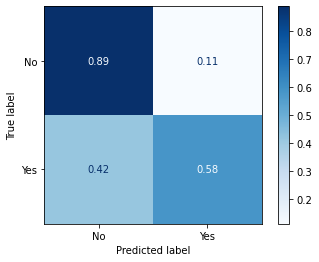

In [15]:
pipeline.fit(train_x,train_y.values.ravel())
predict_y=pipeline.predict(test_x)
plot_confusion_matrix(pipeline, test_x,test_y,display_labels=["No","Yes"], cmap=plt.cm.Blues,normalize='true');

### 7. Smote + Tomek

In [16]:
pipeline = Pipeline(steps=[('prep', col_transform),('imbalance',SMOTETomek()) ,('m',rf)])
cv_results_smt=cross_validate(pipeline, train_x, train_y.values.ravel(), scoring=scoring, cv=kfold)

results = pd.DataFrame(columns=scoring.keys())
results.loc['SMT']=  [np.mean(cv_results_smt['test_{}'.format(score)]) for score in scoring.keys()] 
results

,Acc,F1,Prec,Recall,MC,GM
SMT,0.888437,0.423928,0.507009,0.364496,0.370177,0.589845


<IPython.core.display.Javascript object>

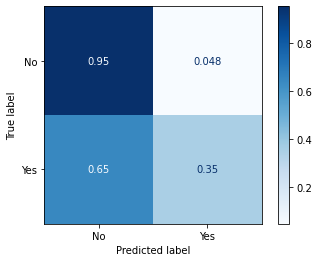

In [17]:
pipeline.fit(train_x,train_y.values.ravel())
predict_y=pipeline.predict(test_x)
plot_confusion_matrix(pipeline, test_x,test_y,display_labels=["No","Yes"], cmap=plt.cm.Blues,normalize='true');

### 8. Algorithm modification: Cost Sensitive learning

In [18]:
pipeline = Pipeline(steps=[('prep', col_transform0),('m',RandomForestClassifier(class_weight='balanced'))])
cv_results_cost=cross_validate(pipeline, train_x, train_y.values.ravel(), scoring=scoring, cv=kfold)

results = pd.DataFrame(columns=scoring.keys())
results.loc['cost_sen']=  [np.mean(cv_results_cost['test_{}'.format(score)]) for score in scoring.keys()] 
results

,Acc,F1,Prec,Recall,MC,GM
cost_sen,0.837481,0.304838,0.294169,0.316542,0.213226,0.534425


<IPython.core.display.Javascript object>

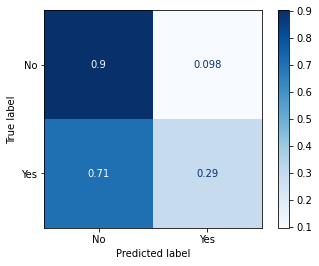

In [19]:
pipeline.fit(train_x,train_y.values.ravel())
predict_y=pipeline.predict(test_x)
plot_confusion_matrix(pipeline, test_x,test_y,display_labels=["No","Yes"], cmap=plt.cm.Blues,normalize='true');

### All methods

In [20]:
cv_result=[cv_results_none,cv_results_smote,cv_results_adasyn,cv_results_ncr,
         cv_results_oss,cv_results_smeenn,cv_results_smt,cv_results_cost]

methods=["No sampling","smote","adasyn","ncr","oss","smeenn","smt","Cost sensitive"]
results = pd.DataFrame(columns=scoring.keys())

for i,j in zip(methods,cv_result):
    results.loc[i]=  [np.mean(j['test_{}'.format(score)]) for score in scoring.keys()] 

results 

,Acc,F1,Prec,Recall,MC,GM
No sampling,0.886829,0.334538,0.495452,0.252693,0.298870,0.494100
smote,0.887375,0.422630,0.500287,0.366111,0.367421,0.590684
adasyn,0.886009,0.411002,0.491798,0.353182,0.355732,0.580149
ncr,0.873687,0.477718,0.447251,0.512931,0.407581,0.686670
oss,0.891138,0.424114,0.525346,0.355873,0.375051,0.584104
smeenn,0.854932,0.479357,0.402411,0.592939,0.408831,0.725610
smt,0.888437,0.423928,0.507009,0.364496,0.370177,0.589845
Cost sensitive,0.837481,0.304838,0.294169,0.316542,0.213226,0.534425


## References


 He, H., Bai, Y., Garcia, E. A., & Li, S. (2008, June). ADASYN: Adaptive synthetic sampling approach for imbalanced learning. In 2008 IEEE international joint conference on neural networks (IEEE world congress on computational intelligence) (pp. 1322-1328). IEEE.

<a href="https://machinelearningmastery.com/fbeta-measure-for-machine-learning/">A Gentle Introduction to the Fbeta-Measure for Machine Learning</a> 

 "Alberto Fernández, Salvador García, Mikel Galar, Ronaldo C. Prati, Bartosz Krawczyk, Francisco Herrera - Learning from Imbalanced Data Sets-Springer International Publishing (2018)"
 
 Batista, G. E., Prati, R. C., & Monard, M. C. (2004). A study of the behavior of several methods for balancing machine learning training data. ACM SIGKDD explorations newsletter, 6(1), 20-29.
 
 He, H., Bai, Y., Garcia, E. A., & Li, S. (2008, June). ADASYN: Adaptive synthetic sampling approach for imbalanced learning. In 2008 IEEE international joint conference on neural networks (IEEE world congress on computational intelligence) (pp. 1322-1328). IEEE.